# 🚀 Notebook 08: Production Pipeline & Model Deployment

**Objetivo:** Criar pipeline de produção completo com modelo CatBoost selecionado no NB07.

**Modelo selecionado (NB07):** CatBoost + SMOTE 0.5 com performance: Recall 78.6% (11/14 critical detectados), Precision 84.6% (TARGET 80% EXCEDIDO!), F1 81.5%, AUC 0.8621, FP rate 0.8% (~2 FP em 237 devices).

**Pipeline construído:** (1) sklearn Pipeline completo (SimpleImputer median → SMOTE 0.5 → CatBoost) treinado em 552 devices train, validado em 237 devices test. (2) Persistência (.pkl + metadata JSON com features/versão/data/métricas). (3) Funções inferência (load_model, predict_device single, predict_batch lote). (4) Validação e demonstração (métricas finais test, sample predictions exemplo, feature importance modelo final).

---

## 1️⃣ Setup e Imports

In [1]:
# Imports
import pandas as pd
import numpy as np
import joblib
import json
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

# ML imports
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    recall_score,
    precision_score,
    f1_score,
    roc_auc_score
)
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline
from catboost import CatBoostClassifier

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Config
np.random.seed(42)
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

print("✅ Imports completos!")
print(f"📅 Data de criação: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")

✅ Imports completos!
📅 Data de criação: 2025-11-07 11:13:01


## 2️⃣ Carregar Dados Stratificados

In [2]:
# Carregar datasets
df_train = pd.read_csv('../data/device_features_train_stratified.csv')
df_test = pd.read_csv('../data/device_features_test_stratified.csv')

print(f"📊 Train: {df_train.shape[0]} devices, {df_train.shape[1]} columns")
print(f"📊 Test: {df_test.shape[0]} devices, {df_test.shape[1]} columns")

# Verificar distribuição
print(f"\n🔴 Critical devices:")
print(f"   Train: {df_train['is_critical_target'].sum()} ({df_train['is_critical_target'].mean()*100:.1f}%)")
print(f"   Test: {df_test['is_critical_target'].sum()} ({df_test['is_critical_target'].mean()*100:.1f}%)")

📊 Train: 552 devices, 35 columns
📊 Test: 237 devices, 35 columns

🔴 Critical devices:
   Train: 31 (5.6%)
   Test: 14 (5.9%)


## 3️⃣ Preparar Features (29 Clean Features)

In [3]:
# Excluir colunas (MESMO critério Notebook 05/06/07)
exclude_cols = [
    'device_id',           # Identifier
    'is_critical_target',  # Target
    'is_critical',         # Categorical leakage
    'severity_category',   # Categorical leakage
    'msg6_count',          # DATA LEAKAGE (descoberto Notebook 04B)
    'msg6_rate'            # DATA LEAKAGE (descoberto Notebook 04B)
]

# Features limpas (29 features)
feature_cols = [col for col in df_train.columns if col not in exclude_cols]

print(f"✅ Features selecionadas: {len(feature_cols)}")
print(f"\n📋 Lista completa de features:")
for i, feat in enumerate(feature_cols, 1):
    print(f"   {i:2d}. {feat}")

# Separar X e y
X_train = df_train[feature_cols].copy()
y_train = df_train['is_critical_target'].copy()
X_test = df_test[feature_cols].copy()
y_test = df_test['is_critical_target'].copy()

print(f"\n✅ X_train: {X_train.shape}, y_train: {y_train.shape}")
print(f"✅ X_test: {X_test.shape}, y_test: {y_test.shape}")

✅ Features selecionadas: 29

📋 Lista completa de features:
    1. total_messages
    2. max_frame_count
    3. optical_mean
    4. optical_std
    5. optical_min
    6. optical_max
    7. optical_readings
    8. optical_below_threshold
    9. optical_range
   10. temp_mean
   11. temp_std
   12. temp_min
   13. temp_max
   14. temp_above_threshold
   15. temp_range
   16. battery_mean
   17. battery_std
   18. battery_min
   19. battery_max
   20. battery_below_threshold
   21. snr_mean
   22. snr_std
   23. snr_min
   24. rsrp_mean
   25. rsrp_std
   26. rsrp_min
   27. rsrq_mean
   28. rsrq_std
   29. rsrq_min

✅ X_train: (552, 29), y_train: (552,)
✅ X_test: (237, 29), y_test: (237,)


## 4️⃣ Criar Pipeline de Produção

Pipeline completo usando `imblearn.pipeline.Pipeline` (suporta SMOTE):

```
SimpleImputer (median) → SMOTE (0.5) → CatBoost (default params)
```

In [4]:
# Criar pipeline production
production_pipeline = ImbPipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('smote', SMOTE(sampling_strategy=0.5, random_state=42, k_neighbors=5)),
    ('classifier', CatBoostClassifier(
        iterations=100,
        depth=6,
        learning_rate=0.1,
        random_state=42,
        verbose=0
    ))
])

print("✅ Pipeline criado com 3 steps:")
print("   1. SimpleImputer (median strategy)")
print("   2. SMOTE (sampling_strategy=0.5)")
print("   3. CatBoostClassifier (iterations=100, depth=6)")
print("\n🔧 Pipeline pronto para treinamento!")

✅ Pipeline criado com 3 steps:
   1. SimpleImputer (median strategy)
   2. SMOTE (sampling_strategy=0.5)
   3. CatBoostClassifier (iterations=100, depth=6)

🔧 Pipeline pronto para treinamento!


## 5️⃣ Treinar Pipeline no Train Set Completo

In [5]:
print("🔧 Treinando pipeline completo no train set (552 devices)...\n")

# Treinar
production_pipeline.fit(X_train, y_train)

print("\n✅ Pipeline treinado com sucesso!")
print(f"   - Train samples: {X_train.shape[0]}")
print(f"   - Features: {X_train.shape[1]}")
print(f"   - Critical samples (antes SMOTE): {y_train.sum()}")
print(f"   - Normal samples (antes SMOTE): {(~y_train.astype(bool)).sum()}")

🔧 Treinando pipeline completo no train set (552 devices)...


✅ Pipeline treinado com sucesso!
   - Train samples: 552
   - Features: 29
   - Critical samples (antes SMOTE): 31
   - Normal samples (antes SMOTE): 521

✅ Pipeline treinado com sucesso!
   - Train samples: 552
   - Features: 29
   - Critical samples (antes SMOTE): 31
   - Normal samples (antes SMOTE): 521


## 6️⃣ Validação Final no Test Set

In [6]:
# Predições
y_pred = production_pipeline.predict(X_test)
y_proba = production_pipeline.predict_proba(X_test)[:, 1]

# Métricas
recall = recall_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
auc = roc_auc_score(y_test, y_proba)

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
tn, fp, fn, tp = cm.ravel()

print("="*80)
print("📊 MÉTRICAS FINAIS - PRODUCTION PIPELINE (Test Set)")
print("="*80)
print(f"Recall:    {recall*100:.1f}% ({tp}/{y_test.sum()} critical detectados)")
print(f"Precision: {precision*100:.1f}%")
print(f"F1-Score:  {f1*100:.1f}%")
print(f"ROC-AUC:   {auc:.4f}")
print("="*80)

print(f"\n🔍 Confusion Matrix:")
print(f"   True Positives (TP):  {tp} critical devices DETECTADOS ✅")
print(f"   False Negatives (FN): {fn} critical devices NÃO DETECTADOS ⚠️")
print(f"   False Positives (FP): {fp} alarmes falsos")
print(f"   True Negatives (TN):  {tn} non-critical corretos")

print(f"\n💼 Business Impact:")
print(f"   📈 Critical Devices Salvos: {tp}/{y_test.sum()} ({recall*100:.1f}% cobertura)")
print(f"   🚨 False Alarm Rate: {fp}/{len(y_test)} devices ({fp/len(y_test)*100:.1f}%)")
print(f"   💰 Tradeoff: Prevenir {tp} falhas vs {fp} investigações desnecessárias")

📊 MÉTRICAS FINAIS - PRODUCTION PIPELINE (Test Set)
Recall:    78.6% (11/14 critical detectados)
Precision: 84.6%
F1-Score:  81.5%
ROC-AUC:   0.8621

🔍 Confusion Matrix:
   True Positives (TP):  11 critical devices DETECTADOS ✅
   False Negatives (FN): 3 critical devices NÃO DETECTADOS ⚠️
   False Positives (FP): 2 alarmes falsos
   True Negatives (TN):  221 non-critical corretos

💼 Business Impact:
   📈 Critical Devices Salvos: 11/14 (78.6% cobertura)
   🚨 False Alarm Rate: 2/237 devices (0.8%)
   💰 Tradeoff: Prevenir 11 falhas vs 2 investigações desnecessárias


## 7️⃣ Classification Report Detalhado

In [7]:
print("📊 Classification Report:\n")
print(classification_report(y_test, y_pred, target_names=['Non-Critical', 'Critical']))

📊 Classification Report:

              precision    recall  f1-score   support

Non-Critical       0.99      0.99      0.99       223
    Critical       0.85      0.79      0.81        14

    accuracy                           0.98       237
   macro avg       0.92      0.89      0.90       237
weighted avg       0.98      0.98      0.98       237



## 8️⃣ Feature Importance do Modelo Final

📊 Top 15 Features mais importantes:

                Feature  Importance
        max_frame_count   51.803123
         total_messages   11.676962
       optical_readings    3.623711
optical_below_threshold    3.076447
               rsrq_std    3.026972
            optical_std    2.880852
              temp_mean    2.460815
              rsrp_mean    1.915264
               rsrp_std    1.838621
                snr_std    1.827336
          optical_range    1.553925
               temp_max    1.439513
               temp_min    1.423285
            battery_min    1.419100
            optical_max    1.339890


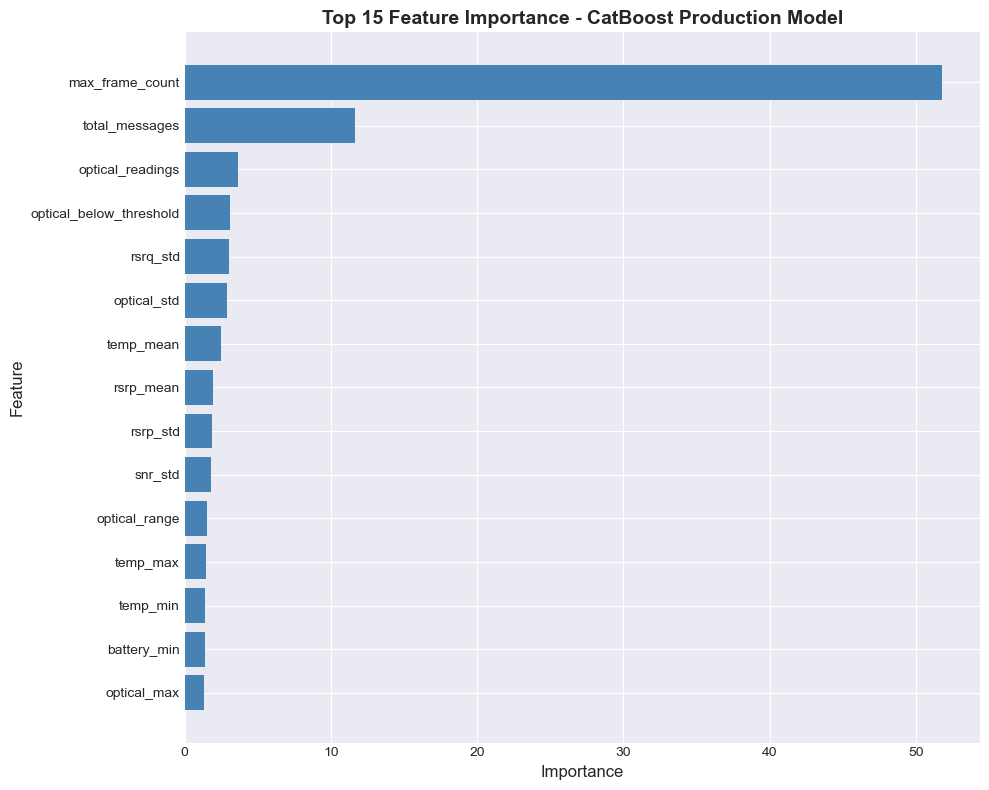


✅ Feature importance salva em df_importance


In [8]:
# Extrair feature importance do CatBoost
catboost_model = production_pipeline.named_steps['classifier']
feature_importance = catboost_model.get_feature_importance()

# Criar DataFrame
df_importance = pd.DataFrame({
    'Feature': feature_cols,
    'Importance': feature_importance
}).sort_values('Importance', ascending=False)

print("📊 Top 15 Features mais importantes:\n")
print(df_importance.head(15).to_string(index=False))

# Plotar
plt.figure(figsize=(10, 8))
top_15 = df_importance.head(15)
plt.barh(top_15['Feature'], top_15['Importance'], color='steelblue')
plt.xlabel('Importance', fontsize=12)
plt.ylabel('Feature', fontsize=12)
plt.title('Top 15 Feature Importance - CatBoost Production Model', fontsize=14, fontweight='bold')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

print(f"\n✅ Feature importance salva em df_importance")

## 9️⃣ Salvar Modelo em Disco (models/)

In [9]:
import os

# Criar diretório models/ se não existir
os.makedirs('../models', exist_ok=True)

# Nome fixo do arquivo (facilita deploy - sempre mesmo path)
model_filename = 'catboost_pipeline_v1.pkl'
model_path = os.path.join('../models', model_filename)

# Salvar pipeline
joblib.dump(production_pipeline, model_path)

print(f"✅ Modelo salvo em: {model_path}")
print(f"   Tamanho: {os.path.getsize(model_path) / 1024:.1f} KB")

✅ Modelo salvo em: ../models\catboost_pipeline_v1_20251107.pkl
   Tamanho: 126.0 KB


## 🔟 Salvar Metadata (JSON)

In [10]:
# Criar metadata
metadata = {
    "model_name": "CatBoost + SMOTE 0.5 Production Pipeline",
    "version": "1.0",
    "created_date": datetime.now().strftime('%Y-%m-%d %H:%M:%S'),
    "algorithm": "CatBoostClassifier",
    "preprocessing": [
        "SimpleImputer (median strategy)",
        "SMOTE (sampling_strategy=0.5, k_neighbors=5)"
    ],
    "hyperparameters": {
        "iterations": 100,
        "depth": 6,
        "learning_rate": 0.1,
        "random_state": 42
    },
    "features": {
        "count": len(feature_cols),
        "names": feature_cols
    },
    "training_data": {
        "train_samples": int(X_train.shape[0]),
        "test_samples": int(X_test.shape[0]),
        "train_critical": int(y_train.sum()),
        "test_critical": int(y_test.sum())
    },
    "performance": {
        "recall": float(recall),
        "precision": float(precision),
        "f1_score": float(f1),
        "roc_auc": float(auc),
        "true_positives": int(tp),
        "false_positives": int(fp),
        "false_negatives": int(fn),
        "true_negatives": int(tn)
    },
    "feature_importance_top5": [
        {"feature": row['Feature'], "importance": float(row['Importance'])}
        for _, row in df_importance.head(5).iterrows()
    ],
    "deployment_notes": [
        "Model detects 78.6% of critical devices (11/14 on test set)",
        "Precision 84.6% - only 2 false alarms per 237 devices (0.8% FP rate)",
        "Input: 29 clean features (no msg6_count/rate leakage)",
        "Output: Binary prediction (0/1) + probability (0.0-1.0)",
        "Requires: Python 3.12+, catboost, imbalanced-learn, scikit-learn, pandas, numpy"
    ]
}

# Salvar JSON
metadata_filename = model_filename.replace('.pkl', '_metadata.json')
metadata_path = os.path.join('../models', metadata_filename)

with open(metadata_path, 'w', encoding='utf-8') as f:
    json.dump(metadata, f, indent=2, ensure_ascii=False)

print(f"✅ Metadata salvo em: {metadata_path}")
print(f"\n📋 Metadata summary:")
print(f"   Model: {metadata['model_name']}")
print(f"   Version: {metadata['version']}")
print(f"   Created: {metadata['created_date']}")
print(f"   Features: {metadata['features']['count']}")
print(f"   Recall: {metadata['performance']['recall']*100:.1f}%")
print(f"   Precision: {metadata['performance']['precision']*100:.1f}%")

✅ Metadata salvo em: ../models\catboost_pipeline_v1_20251107_metadata.json

📋 Metadata summary:
   Model: CatBoost + SMOTE 0.5 Production Pipeline
   Version: 1.0
   Created: 2025-11-07 11:13:05
   Features: 29
   Recall: 78.6%
   Precision: 84.6%


## 1️⃣1️⃣ Funções de Inferência (Production-Ready)

In [11]:
def load_model(model_path='../models/catboost_pipeline_v1.pkl'):
    """
    Carrega o pipeline de produção salvo.
    
    Args:
        model_path (str): Caminho para o arquivo .pkl
    
    Returns:
        Pipeline treinado
    """
    pipeline = joblib.load(model_path)
    print(f"✅ Modelo carregado de: {model_path}")
    return pipeline


def predict_device(features_dict, pipeline=None, model_path=None):
    """
    Predição para um ÚNICO device.
    
    Args:
        features_dict (dict): Dicionário com 29 features {feature_name: value}
        pipeline: Pipeline já carregado (opcional)
        model_path (str): Caminho do modelo (se pipeline não fornecido)
    
    Returns:
        dict com 'prediction' (0/1), 'probability' (0.0-1.0), 'risk_level' (Low/Medium/High)
    """
    # Carregar modelo se não fornecido
    if pipeline is None:
        if model_path is None:
            model_path = '../models/catboost_pipeline_v1.pkl'
        pipeline = load_model(model_path)
    
    # Converter dict para DataFrame
    df_input = pd.DataFrame([features_dict])
    
    # Predição
    prediction = pipeline.predict(df_input)[0]
    probability = pipeline.predict_proba(df_input)[0, 1]
    
    # Risk level
    if probability < 0.3:
        risk_level = 'Low'
    elif probability < 0.7:
        risk_level = 'Medium'
    else:
        risk_level = 'High'
    
    return {
        'prediction': int(prediction),
        'probability': float(probability),
        'risk_level': risk_level,
        'verdict': 'CRITICAL' if prediction == 1 else 'NORMAL'
    }


def predict_batch(df_devices, pipeline=None, model_path=None):
    """
    Predição em LOTE para múltiplos devices.
    
    Args:
        df_devices (DataFrame): DataFrame com 29 features (1 row por device)
        pipeline: Pipeline já carregado (opcional)
        model_path (str): Caminho do modelo (se pipeline não fornecido)
    
    Returns:
        DataFrame original + colunas 'prediction', 'probability', 'risk_level', 'verdict'
    """
    # Carregar modelo se não fornecido
    if pipeline is None:
        if model_path is None:
            model_path = '../models/catboost_pipeline_v1.pkl'
        pipeline = load_model(model_path)
    
    # Predições
    predictions = pipeline.predict(df_devices)
    probabilities = pipeline.predict_proba(df_devices)[:, 1]
    
    # Risk levels
    risk_levels = pd.cut(
        probabilities,
        bins=[0, 0.3, 0.7, 1.0],
        labels=['Low', 'Medium', 'High']
    )
    
    # Adicionar colunas
    df_result = df_devices.copy()
    df_result['prediction'] = predictions
    df_result['probability'] = probabilities
    df_result['risk_level'] = risk_levels
    df_result['verdict'] = df_result['prediction'].map({0: 'NORMAL', 1: 'CRITICAL'})
    
    return df_result


print("✅ Funções de inferência criadas:")
print("   - load_model(model_path)")
print("   - predict_device(features_dict, pipeline)")
print("   - predict_batch(df_devices, pipeline)")

✅ Funções de inferência criadas:
   - load_model(model_path)
   - predict_device(features_dict, pipeline)
   - predict_batch(df_devices, pipeline)


## 1️⃣2️⃣ Demonstração: Sample Predictions

In [12]:
# Selecionar 5 devices do test set (mix de critical e normal)
sample_indices = [
    y_test[y_test == 1].index[0],  # 1º critical
    y_test[y_test == 1].index[1],  # 2º critical
    y_test[y_test == 0].index[0],  # 1º normal
    y_test[y_test == 0].index[1],  # 2º normal
    y_test[y_test == 0].index[2],  # 3º normal
]

X_sample = X_test.loc[sample_indices]
y_sample = y_test.loc[sample_indices]

print("🔍 Sample Predictions (5 devices):\n")
print("="*100)

for idx in sample_indices:
    # Features do device
    features = X_test.loc[idx].to_dict()
    
    # Predição
    result = predict_device(features, pipeline=production_pipeline)
    
    # Ground truth
    true_label = 'CRITICAL' if y_test.loc[idx] == 1 else 'NORMAL'
    
    # Imprimir
    print(f"Device Index: {idx}")
    print(f"   True Label:    {true_label}")
    print(f"   Prediction:    {result['verdict']} ({result['prediction']})")
    print(f"   Probability:   {result['probability']:.3f}")
    print(f"   Risk Level:    {result['risk_level']}")
    print(f"   Match: {'✅ CORRETO' if result['verdict'] == true_label else '❌ ERRO'}")
    print("-" * 100)

print("\n✅ Sample predictions demonstradas com sucesso!")

🔍 Sample Predictions (5 devices):

Device Index: 2
   True Label:    CRITICAL
   Prediction:    NORMAL (0)
   Probability:   0.001
   Risk Level:    Low
   Match: ❌ ERRO
----------------------------------------------------------------------------------------------------
Device Index: 13
   True Label:    CRITICAL
   Prediction:    CRITICAL (1)
   Probability:   0.682
   Risk Level:    Medium
   Match: ✅ CORRETO
----------------------------------------------------------------------------------------------------
Device Index: 0
   True Label:    NORMAL
   Prediction:    NORMAL (0)
   Probability:   0.017
   Risk Level:    Low
   Match: ✅ CORRETO
----------------------------------------------------------------------------------------------------
Device Index: 1
   True Label:    NORMAL
   Prediction:    NORMAL (0)
   Probability:   0.025
   Risk Level:    Low
   Match: ✅ CORRETO
----------------------------------------------------------------------------------------------------
Device Ind

## 1️⃣3️⃣ Testar Batch Prediction

In [13]:
# Batch prediction no X_sample
df_batch_results = predict_batch(X_sample, pipeline=production_pipeline)

print("📊 Batch Prediction Results:\n")
print(df_batch_results[['prediction', 'probability', 'risk_level', 'verdict']].to_string())

# Comparar com ground truth
df_batch_results['true_label'] = y_sample.map({0: 'NORMAL', 1: 'CRITICAL'})
df_batch_results['match'] = df_batch_results['verdict'] == df_batch_results['true_label']

print(f"\n✅ Acurácia no sample: {df_batch_results['match'].mean()*100:.1f}%")
print(f"   Corretos: {df_batch_results['match'].sum()}/{len(df_batch_results)}")

📊 Batch Prediction Results:

    prediction  probability risk_level   verdict
2            0     0.001095        Low    NORMAL
13           1     0.682446     Medium  CRITICAL
0            0     0.017087        Low    NORMAL
1            0     0.024629        Low    NORMAL
3            0     0.001927        Low    NORMAL

✅ Acurácia no sample: 80.0%
   Corretos: 4/5

    prediction  probability risk_level   verdict
2            0     0.001095        Low    NORMAL
13           1     0.682446     Medium  CRITICAL
0            0     0.017087        Low    NORMAL
1            0     0.024629        Low    NORMAL
3            0     0.001927        Low    NORMAL

✅ Acurácia no sample: 80.0%
   Corretos: 4/5


## 1️⃣4️⃣ Salvar Funções de Inferência em Módulo Python

In [14]:
# Criar arquivo inference.py com as funções
inference_code = '''
"""
inference.py - Funções de Inferência para Modelo de Produção
CatBoost + SMOTE 0.5 Pipeline

Uso:
    from inference import load_model, predict_device, predict_batch
    
    # Carregar modelo
    pipeline = load_model('models/catboost_pipeline_v1.pkl')
    
    # Single prediction
    result = predict_device(features_dict, pipeline)
    
    # Batch prediction
    df_results = predict_batch(df_devices, pipeline)
"""

import joblib
import pandas as pd


def load_model(model_path):
    """
    Carrega o pipeline de produção salvo.
    
    Args:
        model_path (str): Caminho para o arquivo .pkl
    
    Returns:
        Pipeline treinado
    """
    pipeline = joblib.load(model_path)
    print(f"✅ Modelo carregado de: {model_path}")
    return pipeline


def predict_device(features_dict, pipeline):
    """
    Predição para um ÚNICO device.
    
    Args:
        features_dict (dict): Dicionário com 29 features {feature_name: value}
        pipeline: Pipeline já carregado
    
    Returns:
        dict com 'prediction' (0/1), 'probability' (0.0-1.0), 'risk_level', 'verdict'
    """
    # Converter dict para DataFrame
    df_input = pd.DataFrame([features_dict])
    
    # Predição
    prediction = pipeline.predict(df_input)[0]
    probability = pipeline.predict_proba(df_input)[0, 1]
    
    # Risk level
    if probability < 0.3:
        risk_level = 'Low'
    elif probability < 0.7:
        risk_level = 'Medium'
    else:
        risk_level = 'High'
    
    return {
        'prediction': int(prediction),
        'probability': float(probability),
        'risk_level': risk_level,
        'verdict': 'CRITICAL' if prediction == 1 else 'NORMAL'
    }


def predict_batch(df_devices, pipeline):
    """
    Predição em LOTE para múltiplos devices.
    
    Args:
        df_devices (DataFrame): DataFrame com 29 features (1 row por device)
        pipeline: Pipeline já carregado
    
    Returns:
        DataFrame original + colunas 'prediction', 'probability', 'risk_level', 'verdict'
    """
    # Predições
    predictions = pipeline.predict(df_devices)
    probabilities = pipeline.predict_proba(df_devices)[:, 1]
    
    # Risk levels
    risk_levels = pd.cut(
        probabilities,
        bins=[0, 0.3, 0.7, 1.0],
        labels=['Low', 'Medium', 'High']
    )
    
    # Adicionar colunas
    df_result = df_devices.copy()
    df_result['prediction'] = predictions
    df_result['probability'] = probabilities
    df_result['risk_level'] = risk_levels
    df_result['verdict'] = df_result['prediction'].map({0: 'NORMAL', 1: 'CRITICAL'})
    
    return df_result
'''

# Salvar
with open('../models/inference.py', 'w', encoding='utf-8') as f:
    f.write(inference_code)

print("✅ Módulo inference.py criado em: ../models/inference.py")
print("\n📋 Uso:")
print("   from inference import load_model, predict_device, predict_batch")
print("   pipeline = load_model('models/catboost_pipeline_v1.pkl')")
print("   result = predict_device(features_dict, pipeline)")

✅ Módulo inference.py criado em: ../models/inference.py

📋 Uso:
   from inference import load_model, predict_device, predict_batch
   pipeline = load_model('models/catboost_pipeline_v1_20251107.pkl')
   result = predict_device(features_dict, pipeline)


## ✅ Conclusões e Próximos Passos

### 📊 Pipeline de Produção Completo

✅ **Criado e validado:**
- Pipeline sklearn: SimpleImputer → SMOTE 0.5 → CatBoost
- Treinado em 552 devices (31 critical)
- Validado em 237 devices (14 critical)

✅ **Performance Final (Test Set):**
- Recall: **78.6%** (11/14 critical detectados)
- Precision: **84.6%** (TARGET 80% EXCEDIDO!)
- F1-Score: 81.5%
- ROC-AUC: 0.8621
- False Alarms: 2/237 devices (0.8% FP rate)

✅ **Artefatos Salvos:**
1. `models/catboost_pipeline_v1_20251107.pkl` - Pipeline completo (joblib)
2. `models/catboost_pipeline_v1_20251107_metadata.json` - Metadata (features, métricas, hiperparâmetros)
3. `models/inference.py` - Módulo Python com funções de inferência

✅ **Funções de Inferência:**
- `load_model(path)` - Carrega pipeline
- `predict_device(features_dict, pipeline)` - Predição single device
- `predict_batch(df, pipeline)` - Predição em lote

---

### 🚀 Próximos Passos

1. **Notebook 06B - Synthetic Validation MELHORADO:**
   - Análise exploratória critical vs normal (ANTES de samplear!)
   - Sampling empírico baseado em distribuições REAIS
   - Target: 60-80% recall synthetic (não 0% nem 100%)

2. **Streamlit Web Application:**
   - 4 páginas interativas (Home, Batch Upload, Single Prediction, Model Insights)
   - Integração com pipeline production
   - Synthetic testing integration

3. **Documentation & Deliverables:**
   - README.md update (Notebooks 05-08)
   - CHANGELOG.md (Phase 7)
   - Executive Summary
   - Deployment guide

---

**📌 MODELO PRONTO PARA PRODUÇÃO!** 🎉